In [50]:
# Importing Modules 
import os 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


# import warnings
# warnings.filterwarnings('ignore')

In [51]:
def get_signals(df):
    df['signal'] = 0
    df['signal'] = np.where(df["prediction"]>df["observed"].shift().describe().loc["25%"], float(1),\
                    np.where(df["prediction"]<df["observed"].shift().describe().loc["75%"], float(-1),0))
    
    return df


In [52]:
def load_etfs(directory):
    
    df = pd.DataFrame()
    
    for root,dirs,files in os.walk(directory):
        for filename in files: 
            etf_path  = (os.path.join(root, filename))
            
            df_etf = pd.read_csv(etf_path, parse_dates=True, infer_datetime_format=True, index_col='Date')
            df_etf.rename(columns={'Close': etf_path[-7:-4]}, inplace=True)
            
            df = pd.concat([df, df_etf.pct_change()], axis=1)
            df.dropna(inplace=True)
            
    return df


In [53]:
def compute_return(df, df_signal):
    
    final_returns = {}
    
    df['return'] = df.sum(axis=1)
    df['return'].iloc[0] = 1
    df['strategy_return'] = df['return'] * df_signal['signal']
    df.dropna(inplace=True)
    
    df['cumulative_return'] = (1 + df["return"]).cumprod()
    df['cumulative_strategy_return'] = (1 + df["strategy_return"]).cumprod()
    
    final_returns['final_return'] = np.round(df['cumulative_return'].iloc[-1], 3)
    final_returns['final_strategy_return'] = np.round(df['cumulative_strategy_return'].iloc[-1], 3)
    
    return df, final_returns



-----------------------
Cyclical ETFs Results:
{'final_return': 0.459, 'final_strategy_return': 0.214}
-----------------------
Defensive ETFs Results:
{'final_return': 1.458, 'final_strategy_return': 0.944}


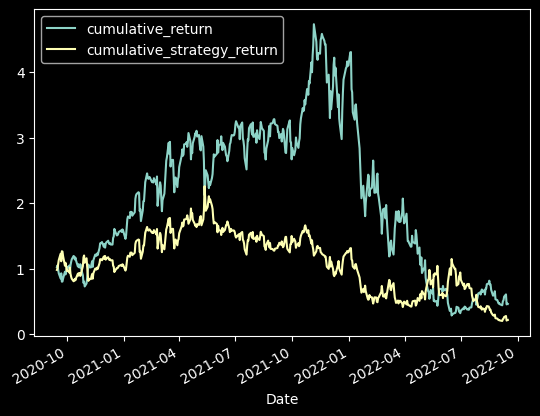

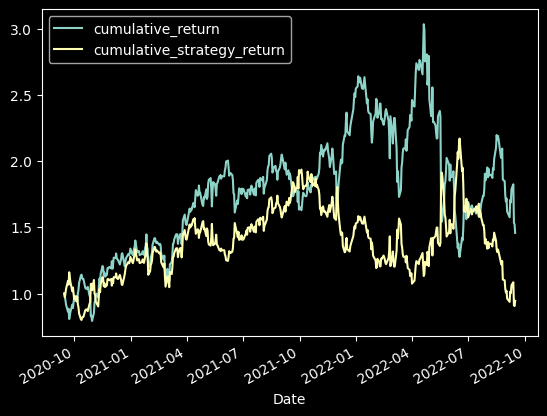

In [54]:
# df_pred = pd.read_csv('./predictions_test.csv', parse_dates=True, infer_datetime_format=True, index_col='Date')
# df_signal = get_signals(df_pred)

# df_cyc = load_etfs('./DATA/ETF_CYC')
# df_def = load_etfs('./DATA/ETF_DEF')
# df_cyc, final_cyc_returns = compute_return(df_cyc, df_signal)
# df_def, final_def_returns = compute_return(df_def, df_signal)

# print('\n-----------------------')
# print('Cyclical ETFs Results:')
# print(final_cyc_returns)
# print('-----------------------')
# print('Defensive ETFs Results:')
# print(final_def_returns)

# defensive_plot = (0 + df_cyc[["cumulative_return", "cumulative_strategy_return"]])
# defensive_plot.plot.line();

# cyclical_plot = (0 + df_def[["cumulative_return", "cumulative_strategy_return"]])
# cyclical_plot.plot.line();